### Analysis of The COVID Tracking Project Numbers
- Twitter: @COVID19Tracking
- Interest primarily in how hospitalizations have changed over time
- Around 25% of those that are hospitalized end up dying

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from state_config import state_conversion

sns.set()
rcParams['font.family'] = 'DejaVu Sans'
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

In [2]:
# data = pd.read_csv('../data/tctp.csv')
us_populations = pd.read_csv('../data/us_populations.csv')
us_populations.rename(columns={'Geographic Area': 'full_name'}, inplace=True)
data = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv')

# Reformat
date_columns = ['date', 'lastUpdateEt', 'dateChecked']
for column in date_columns:
    if column == 'date':
        data[column] = pd.to_datetime(data[column], format='%Y%m%d')
    else:
        data[column] = pd.to_datetime(data[column])
        
# Keep only states and datapoints after certain point in time
data = data[data['date'] > '2020-04-01']
data = data[data['state'].isin(state_conversion.keys())]
data.sort_values('date', ascending=True, inplace=True)

# Look at only data of interest
columns = ['state', 'date', 'hospitalizedIncrease', 'hospitalizedCurrently', 'hospitalizedCumulative', 'positive', 'negative', 'deathIncrease']
data = data.loc[:, columns]

# New features
data['positivity_rate'] = data['positive'] / (data['positive'] + data['negative'])
data['full_name'] = data['state'].map(state_conversion)
data = data.merge(us_populations, how='left', on='full_name')
data['deaths_per_million'] = data['deathIncrease'] / data['Population'] * 1000000
data['hospitalizations_per_million'] = data['hospitalizedCurrently'] / data['Population'] * 1000000

print(data.shape)
data.head()

(6400, 13)


,state,date,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,positive,negative,deathIncrease,positivity_rate,full_name,Population,deaths_per_million,hospitalizations_per_million
0,WY,2020-04-02,1,NaN,19.0,150.0,2439.0,0,0.057937,Wyoming,578759,0.000000,NaN
1,MI,2020-04-02,0,NaN,NaN,21376.0,33443.0,125,0.389938,Michigan,9986857,12.516450,NaN
2,ME,2020-04-02,5,NaN,68.0,376.0,6088.0,0,0.058168,Maine,1344212,0.000000,NaN
3,MD,2020-04-02,60,NaN,582.0,2331.0,18890.0,12,0.109844,Maryland,6045680,1.984888,NaN
4,MA,2020-04-02,131,NaN,813.0,8867.0,47767.0,42,0.156567,Massachusetts,6892503,6.093577,NaN


Notes:
- `hospitalizedCurrently` should be the primary metric of interest. Should want to know if the number of hospitalizations has been increasing. For cases where hospitalized currently is not available, `hospitazliedCumulative` should be used. Should split these two groups.
- **Nebraska started to provide hospitalization data on June 3

In [3]:
# States with hospitazliedCurrently data
hosp_curr_states = [
    'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 
    'CT', 'DE', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 
    'KY', 'LA', 'MA', 'MD', 'ME', 
    'MI', 'MN', 'MO', 'MS', 'MT',
    'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
    'NV', 'NY', 'OH', 'OK', 'OR', 
    'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 
    'VA', 'VT', 'WA', 'WI', 'WV', 'WY'
]
hosp_cum_states = ['HI', 'KS',]

### Currently Hospitalizated

In [4]:
# Get states with currently hospitalized data
temp = (
    data[data['state'].isin(hosp_curr_states)]
    .sort_values(['state', 'date'], ascending=True)
    .fillna(method='bfill')   
)

# Rolling features
temp['deaths_rolling_mean'] = temp.groupby('state')['deaths_per_million'].transform(lambda x: x.rolling(7).mean())
temp['hospitalizations_rolling_mean'] = temp.groupby('state')['hospitalizations_per_million'].transform(lambda x: x.rolling(7).mean())
temp['pr_rolling_mean'] = temp.groupby('state')['positivity_rate'].transform(lambda x: x.rolling(7).mean())

temp.tail()

,state,date,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,positive,negative,deathIncrease,positivity_rate,full_name,Population,deaths_per_million,hospitalizations_per_million,deaths_rolling_mean,hospitalizations_rolling_mean,pr_rolling_mean
6182,WY,2020-08-03,0,19.0,167.0,2848.0,52032.0,1,0.051895,Wyoming,578759,1.727835,32.828863,0.493667,30.113694,0.051441
6226,WY,2020-08-04,2,17.0,169.0,2884.0,52359.0,0,0.052206,Wyoming,578759,0.000000,29.373193,0.246834,30.607361,0.051616
6282,WY,2020-08-05,0,16.0,169.0,2923.0,52791.0,0,0.052464,Wyoming,578759,0.000000,27.645358,0.246834,30.607361,0.051893
6326,WY,2020-08-06,2,16.0,171.0,2958.0,53150.0,0,0.052720,Wyoming,578759,0.000000,27.645358,0.246834,30.113694,0.052135
6376,WY,2020-08-07,5,17.0,176.0,3000.0,53625.0,1,0.052980,Wyoming,578759,1.727835,29.373193,0.493667,29.866860,0.052397


In [5]:
# Get all states and dates
states = temp['state'].unique()
dates = temp['date'].unique()

In [6]:
date = temp['date'].max()
hospitalizations = 300
condition = (temp['date'] == date) & (temp['hospitalizations_per_million'] > hospitalizations)
temp[condition]

,state,date,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,positive,negative,deathIncrease,positivity_rate,full_name,Population,deaths_per_million,hospitalizations_per_million,deaths_rolling_mean,hospitalizations_rolling_mean,pr_rolling_mean
6360,AL,2020-08-07,224,1575.0,11537.0,98301.0,651115.0,21,0.131170,Alabama,4903185,4.282930,321.219779,4.516015,313.965019,0.129855
6364,FL,2020-08-07,599,7144.0,30114.0,518075.0,3378864.0,180,0.132944,Florida,21477737,8.380771,332.623498,7.216775,359.422011,0.131558
6355,LA,2020-08-07,0,1406.0,813.0,128746.0,1376256.0,61,0.085545,Louisiana,4648794,13.121683,302.444032,7.928324,319.499146,0.086128
6373,MS,2020-08-07,66,1136.0,4577.0,65436.0,421776.0,23,0.134307,Mississippi,2976149,7.728108,381.701319,8.880124,392.597471,0.132506
6392,NV,2020-08-07,0,1035.0,22786.0,54533.0,452465.0,20,0.107561,Nevada,3080156,6.493178,336.021942,4.174186,367.699373,0.106014


48


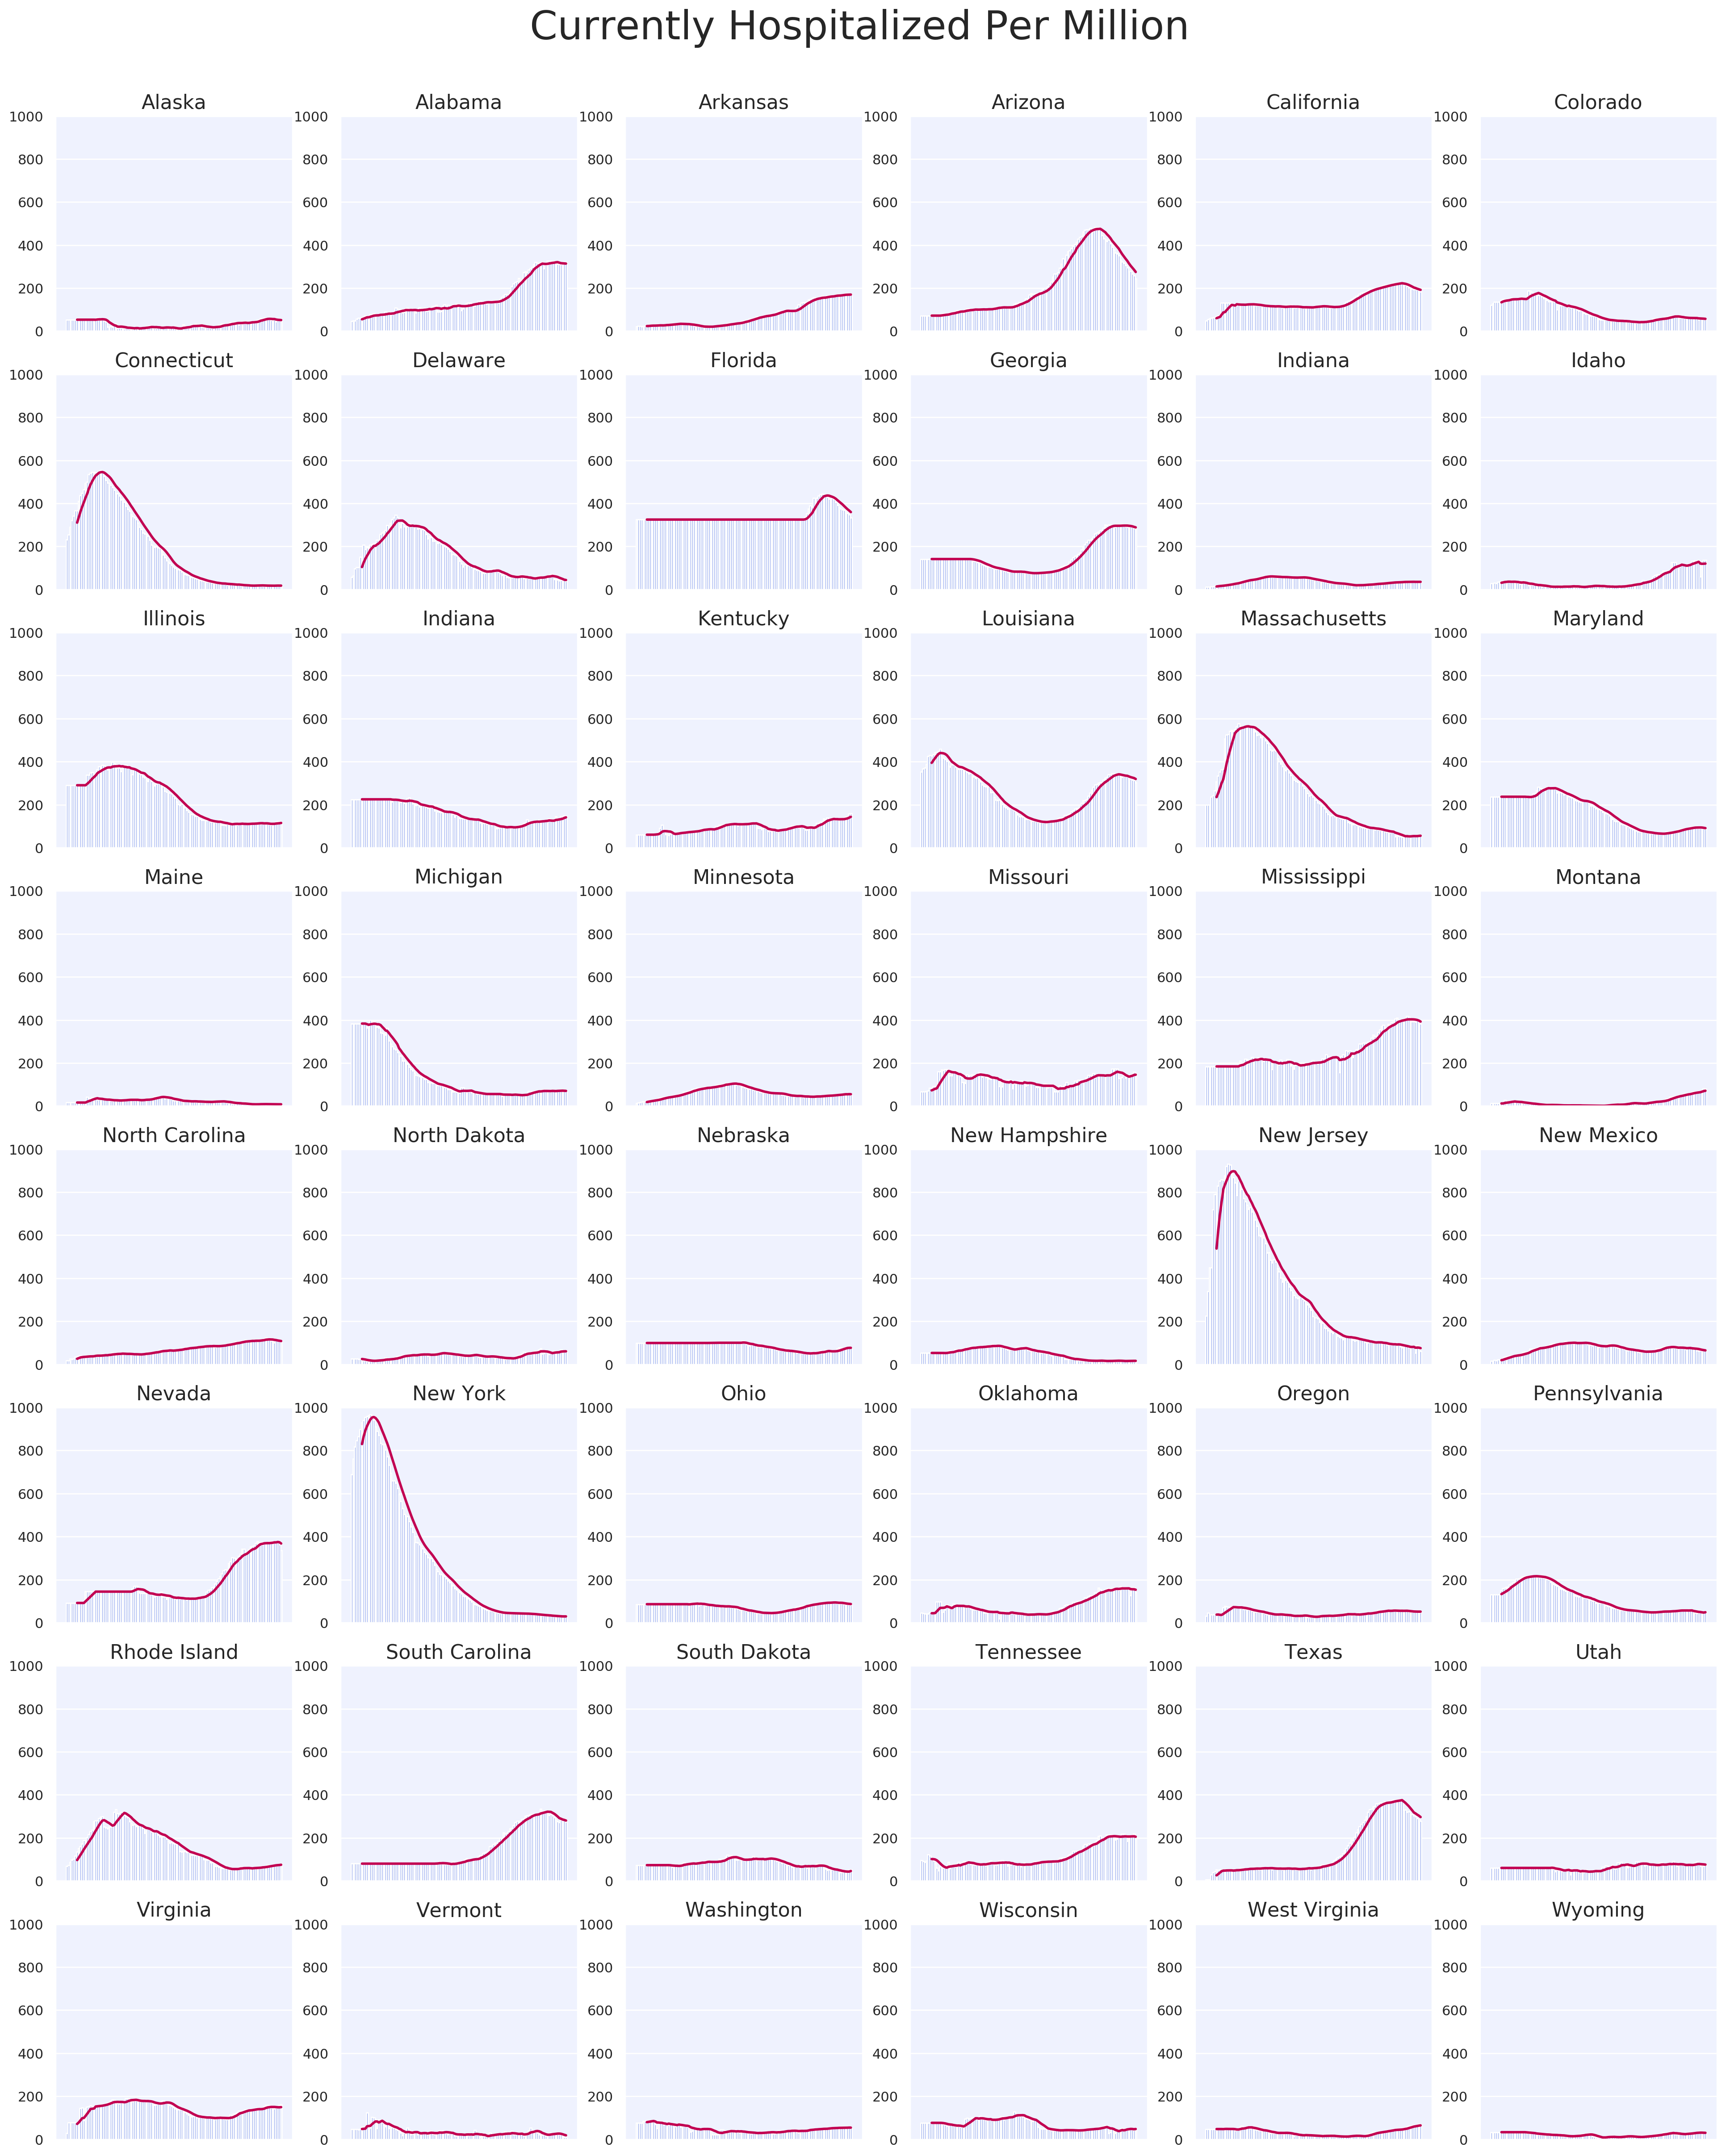

In [7]:
def counts_chart(df, states, dates, feature):
    '''Plot distribution of case counts and the rolling average'''
    
    print(len(states))

    fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(24,30), dpi=200)
    fig.suptitle('Currently Hospitalized Per Million', fontsize=32, y=0.92)

    for index, ax in enumerate(axes.flatten()):

        # Isolate state
        state = states[index]
        state_name = state_conversion[state]
        state_df = df[df['state'] == state]

        # Plot parameters
        ax.set_title(state_name, fontsize=16)
        ax.set_facecolor('#EFF2FE')
        ax.set_ylim(0, 1000)
        ax.tick_params(labelbottom=False)
        ax.xaxis.grid(False)

        # Plot: Distribution of counts per day
        ax.bar(dates, state_df[feature], color='#90A5ED', alpha=1.0, width=1.0)

        # Plot: Rolling Average
        ax.plot(dates, state_df['hospitalizations_rolling_mean'], c='#C20051', alpha=1.0, linewidth=2.0)
        

    plt.savefig('../images/hospitalized_cases.png', dpi=200, bbox_inches='tight')
    plt.show()
    
counts_chart(temp, states, dates, 'hospitalizations_per_million')
# counts_chart(temp, states, dates, 'positivity_rate')

### Old Code

In [8]:
# def dual_axes_plot(df, feature1, feature2, feature3):
    
#     # Get all states and dates
#     states = df['state'].unique()
#     dates = df['date'].unique()

#     fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(20,30), dpi=200)
#     fig.suptitle('Current Hospitalized Cases by State', fontsize=32, y=0.92)

#     for index, ax in enumerate(axes.flatten()):

#         # Isolate state
#         state = states[index]
#         state_name = state_conversion[state]
#         state_df = df[df['state'] == state]

#         # Plot parameters
#         ax.set_title(state_name, fontsize=16)
#         ax.set_facecolor('#EFF2FE')
#         ax.xaxis.grid(False)

#         # Plot: dual axes line plot; ;)
#         ax.plot(dates, state_df[feature1], c='#C20051', alpha=0.9, linewidth=2.0)
#         ax2 = ax.twinx()
#         ax2.plot(dates, state_df[feature2], c='#90A5ED', alpha=0.9, linewidth=2.0)
#         ax3 = ax2.twinx()
#         ax3.plot(dates, state_df[feature3], c='#cccc00', alpha=0.9, linewidth=2.0)
        
#         # Set y-axis limits
#         ax.set_ylim(0, 30)
#         ax2.set_ylim(0, 600)
#         ax3.set_ylim(0, 0.48)
        
#         # Remove tick notation
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
#         ax2.get_yaxis().set_visible(False)
#         ax3.get_yaxis().set_visible(False)

#     plt.savefig('../images/hosp_deaths_pos.png', dpi=200, bbox_inches='tight')
#     plt.show()
    
# dual_axes_plot(temp, 'deaths_rolling_mean', 'hospitalizations_rolling_mean', 'pr_rolling_mean')

In [9]:
# # Get states with cummulative hospital counts
# temp = (
#     data[data['state'].isin(hosp_cum_states)]
#     .sort_values(['state', 'date'], ascending=True)
#     .fillna(method='bfill')   
# )

# temp['hospitalizedIncrease_rolling_mean'] = temp.groupby('state')['hospitalizedIncrease'].transform(lambda x: x.rolling(7).mean())

# temp.head()

In [10]:
# # Get all states and dates
# states = temp['state'].unique()
# dates = temp['date'].unique()

In [11]:
# def counts_chart(df, states, dates):
#     '''Plot distribution of case counts and the rolling average'''

#     fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,10), dpi=200)
#     fig.suptitle('Cumulative Hospitalized Cases by State', fontsize=24)

#     for index, ax in enumerate(axes.flatten()):

#         # Isolate state
#         state = states[index]
#         state_name = state_conversion[state]
#         state_df = df[df['state'] == state]

#         # Plot parameters
#         ax.set_facecolor('#EFF2FE')
#         ax.tick_params(labelbottom=False)
#         ax.xaxis.grid(False)
#         ax.set_title(state_name, fontsize=16)

#         # Plot: Distribution of counts per day
#         ax.bar(dates, state_df['hospitalizedIncrease'], color='#90A5ED', alpha=1.0, width=0.8)

#         # Plot: Rolling Average
#         ax.plot(dates, state_df['hospitalizedIncrease_rolling_mean'], c='#C20051', alpha=1.0, linewidth=2.0)


#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.savefig('../images/hospitalized_cases-cumulative.png')
#     plt.show()
    
# counts_chart(temp, states, dates)